In [1]:
import lxml
import requests
import json
import numpy as np
import csv
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd 
import pickle
from scipy.spatial import distance
import mpu

# Edinburgh transportation network extraction #

**Author:** Ruitao Yi, Abhirup Ghosh  
**Date:** 2019.07.06

## Aims ##

- Use the bus stop name to plot the transportation network
- The distance metric should be harversine rather than Euclidean by using latitude and longitude
- The transportation network should be model as directed graph since the forward and backward path for the same bus line are not exactly the same sometimes. However, this directed graph can be approximately regarded as undirected graph since in most of the cases the forward and the backward path are the same. 

# Step 1: Get the stop id with latitude and longitude

In [2]:
# Get the data from the official website
headers = {'Authorization': '0c627af5849e23b0b030bc7352550884'}
page = requests.get('https://tfe-opendata.com/api/v1/stops', headers=headers)
stops = []
data = page.json()

myfile = open('stops.csv', 'w')    
wr = csv.writer(myfile)
wr.writerow(['stop_id','latitude','longitude'])

for stop in data['stops']:
    stop_id = stop['stop_id']
    lat = stop['latitude']
    lon = stop['longitude']
    mylist = [int(stop_id), lat, lon]
    wr.writerow(mylist)

In [3]:
# Have a glimpse of the data
stops_pd = pd.read_csv("stops.csv", delimiter = ',') 
stops_pd.head(10)

,stop_id,latitude,longitude
0,36234964,55.876587,-3.337471
1,36234954,55.879913,-3.339024
2,36234956,55.883277,-3.338756
3,36234959,55.884161,-3.337556
4,36234945,55.886084,-3.340068
5,36234939,55.888365,-3.338500
6,36237546,55.890341,-3.329453
7,36237548,55.892074,-3.322909
8,36237562,55.893188,-3.319636
9,36237542,55.894375,-3.315327


# Step 2:  Get the bus routes

For each route, there is a service name, e.g. "1_to_Clermiston", where "1" is the name of the bus line and "Clermiston" is the destination. Each service name is associated with a sequence of bus stop ids.

In [4]:
headers = {'Authorization': '0c627af5849e23b0b030bc7352550884'}
page = requests.get('https://tfe-opendata.com/api/v1/services', headers=headers)
routes = {}
services = page.json()['services']

for service in services:
    name = service['name']   # bus route name
    for route in service['routes']: # maybe two routes: forward and backward
        dest = route['destination']
        route_name = name + '_to_' + dest # e.g. "1_to_Clermiston"
        try:
            stops = [int(xi) for xi in route['stops']] # convert type of stop_id to be int 
            routes[route_name] = stops # e.g.  "1_to_Clermiston: stop1, stop2, stop3, ... "
        except:
            print ('service fault:',name)

pickle.dump(routes, open("services.p", "wb"))        

service fault: N28


# Step 3: Get the bus stops with the format --> {stop_id : [lat, lon]}

In [5]:
headers = {'Authorization': '0c627af5849e23b0b030bc7352550884'}
page = requests.get('https://tfe-opendata.com/api/v1/stops', headers=headers)
bus_stops = {}
for stop in page.json()['stops']:
    stop_id = stop['stop_id']
    lat = stop['latitude']
    lon = stop['longitude']
    bus_stops[stop_id] = np.array([lat, lon])

# Step 4: Make sure every bus stop along bus route has lat and lon

In [6]:
# verify if all stops locations are available
routes = pickle.load(open("services.p", "rb"))

for route_name in routes.keys():
    xroute = routes[route_name]
    _new_xroute = []
    for _stop_id in xroute:
        if (len(bus_stops.get(_stop_id, [])) != 0):  # length of [lat, lon]
            _new_xroute.append(_stop_id)
    if (len(xroute) != len(_new_xroute)):
        routes[route_name] = _new_xroute             # make every bus stop has lat and lon

# Step 5: Compute the geometric median
<https://stackoverflow.com/questions/30299267/geometric-median-of-multidimensional-points>

In [7]:
import numpy as np
from scipy.spatial.distance import cdist
def geometric_median(X, eps=1e-5):
    y = np.mean(X, 0)
    while True:
        D = cdist(X, [y])
        nonzeros = (D != 0)[:, 0]
        Dinv = 1 / D[nonzeros]
        Dinvs = np.sum(Dinv)
        W = Dinv / Dinvs
        T = np.sum(W * X[nonzeros], 0)
        num_zeros = len(X) - np.sum(nonzeros)
        if num_zeros == 0:
            y1 = T
        elif num_zeros == len(X):
            return y
        else:
            R = (T - y) * Dinvs
            r = np.linalg.norm(R)
            rinv = 0 if r == 0 else num_zeros/r
            y1 = max(0, 1-rinv)*T + min(1, rinv)*y
        if mpu.haversine_distance(y, y1) < eps:
            return y1
        y = y1

# Step 6: Compute the bus stop names with locations
- Merge the bus stop ids as the same bus stop name if their harversine distance is smaller than 0.5 km

In [8]:
from iteration_utilities import deepflatten
bus_stops_ids = list(set(deepflatten(list(routes.values()), depth=1)))
headers = {'Authorization': '0c627af5849e23b0b030bc7352550884'}
page = requests.get('https://tfe-opendata.com/api/v1/stops', headers=headers)
stops = []
data = page.json()['stops']

bus_stops_name = list(set(map(lambda x: list(filter(lambda y: y['stop_id'] == x, data))[0]['name'], bus_stops_ids)))

def get_locs_and_ids(name):
    l = list(filter(lambda x: x['name'] == name, data))
    l = list(filter(lambda x: x['stop_id'] in bus_stops_ids, l))
    _tmp = [([l[0]['latitude'], l[0]['longitude']], l[0]['stop_id'])]
    for i in range(len(l) - 1):
        _tmp = _tmp + [([l[i+1]['latitude'], l[i+1]['longitude']], l[i+1]['stop_id'])]
    return _tmp

bus_stop_names_locs = dict()
for name in bus_stops_name:
    bus_stop_names_locs[name] = get_locs_and_ids(name)

def calibration(dicts, name):
    locs = dicts[name]
    x = list(filter(lambda x: mpu.haversine_distance((locs[0][0][0],locs[0][0][1]),(x[0][0],x[0][1])) <= 0.5, locs))
    y = list(filter(lambda x: mpu.haversine_distance((locs[0][0][0],locs[0][0][1]),(x[0][0],x[0][1])) > 0.5, locs))
    if len(y) == 0:
        pls = np.asarray(list(map(lambda t: t[0], x)))
        ids = list(map(lambda t: t[1], x))
        del dicts[name]
        dicts[name] = (geometric_median(pls), ids)
    else:
        del dicts[name]
        count = 1
        new_name = name + '_' + str(count)
        if new_name == "Post Office_1":
            print(x)
            print(new_name == "Post Office_1")
        pls = np.asarray(list(map(lambda t: t[0], x)))
        ids = list(map(lambda t: t[1], x))
        dicts[new_name] = (geometric_median(pls), ids)
        while len(y) != 0:
            locs = y
            x = list(filter(lambda x: mpu.haversine_distance((locs[0][0][0],locs[0][0][1]),(x[0][0],x[0][1])) <= 0.5, locs))
            y = list(filter(lambda x: mpu.haversine_distance((locs[0][0][0],locs[0][0][1]),(x[0][0],x[0][1])) > 0.5, locs))
            count += 1
            new_name = name + '_' + str(count)
            pls = np.asarray(list(map(lambda t: t[0], x)))
            ids = list(map(lambda t: t[1], x))
            dicts[new_name] = (geometric_median(pls), ids)

for name in bus_stops_name:
    calibration(bus_stop_names_locs, name)

# Step 7: Build the network

In [9]:
### Build the Networkx road network

graph = nx.Graph()
for _stop_id in bus_stop_names_locs.keys():
    graph.add_node(_stop_id)

for route_name in list(routes.keys()):
#     print(route_name)
    xroute = routes[route_name]
    
    # validation 
    if (len(xroute) != len(routes[route_name])):
        print(len(xroute), len(routes[route_name]))
    
    for ix in range(len(xroute)-1):
        v1, v2 = xroute[ix], xroute[ix+1]
        if (graph.has_edge(v1, v2) == False):
            v1 = list(filter(lambda x: v1 in x[1][1], bus_stop_names_locs.items()))[0][0]
            v2 = list(filter(lambda x: v2 in x[1][1], bus_stop_names_locs.items()))[0][0]
            (lat1, lon1), _ = bus_stop_names_locs[v1]
            (lat2, lon2), _ = bus_stop_names_locs[v2]
            weight = mpu.haversine_distance((lat1, lon1), (lat2, lon2))
            graph.add_edge(v1, v2, weight=weight)

# Step 8: Plot the graph

/afs/ece.cmu.edu/usr/ruitaoy/miniconda3/envs/summer/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


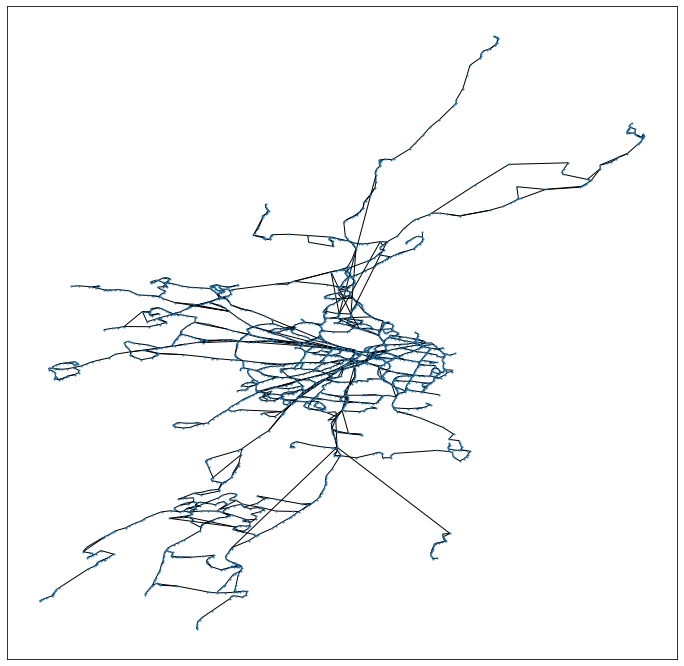

In [10]:
## Plot graph
pos = dict()
for name in bus_stop_names_locs.keys():
    pos[name] = bus_stop_names_locs[name][0]
    
# print(pos)
def plot_graph(graph):
    fig, ax = plt.subplots(figsize=(12,12))
    nx.draw_networkx(graph, pos=pos, ax=ax, with_labels=False, node_size=1)

plot_graph(graph)

# Step 9: Save the results

In [11]:
nx.write_gpickle(graph, "../routes/road_network")
pickle.dump(pos, open("bus_stops.p", "wb"))
pickle.dump(bus_stop_names_locs, open("bus_stop_names_locs.p", "wb"))
new_routes = dict()
for service in list(routes.keys()):
    new_routes[service] = list(map(lambda v: list(filter(lambda x: v in x[1][1], bus_stop_names_locs.items()))[0][0], routes[service]))
pickle.dump(new_routes, open("routes.p", "wb")) 